# Purpose

This notebook demonstrates the data preprocessing tasks and conducts project specific exploratory data analysis (EDA). It aims to clean, transform, and prepare the data for further analysis and modeling.
At the end of this activity, processed data is created from raw data.

# Imports

In [1]:
from pprint import pprint
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd

pd.options.mode.use_inf_as_na = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from numba import NumbaDeprecationWarning

warnings.filterwarnings(
    "ignore",
    message="The default value of regex will change from True to False in a future version.",
    category=FutureWarning,
)
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialization

In [100]:
# standard code-template imports
from ta_lib.core.api import (
    create_context,
    display_as_tabs,
    initialize_environment,
    list_datasets,
    load_dataset,
    save_dataset,
)
from ta_lib.mmx.eda import (
    generate_quarterly_spends_data,
    generate_spends_vs_activity_data,
    get_spend_vs_activity_plot,
    get_quarterly_spends_plot,
)
from ta_lib.mmx.feature_engineering import (
    add_fiscal_calendar,
    add_linear_trend,
    create_adstock,
    create_lag,
    get_scurve_transform,
    get_seasonality_column,
    remove_columns_with_all_zeros,
)

In [5]:
initialize_environment(debug=False, hide_warnings=True)

# 1. Utility functions

In [6]:
config_path = op.join("conf", "config.yml")
context = create_context(config_path)
pprint(list_datasets(context))

activity_df = load_dataset(context, "raw/mmx")

['/raw/mmx', '/cleaned/mmx', '/processed/mmx']
{'type': 'ds', 'format': 'csv', 'uri': '/home/mangeshshinde/MMX_practice_1/mmx-py/src/../data/raw/mmx/lowes_data.csv', 'driver_params': {}}
['/home/mangeshshinde/MMX_practice_1/mmx-py/src/../data/raw/mmx/lowes_data.csv']


# 2. Data cleaning and consolidation

**<u>NOTES</u>**

The focus here is to create a cleaned dataset that is appropriate for solving the DS problem at hand from the raw data.

**1. Do**
* clean dataframe column names
* ensure dtypes are set properly
* join with other tables etc to create features
* transform, if appropriate, datetime like columns to generate additional features (weekday etc)
* transform, if appropriate, string columns to generate additional features
* discard cols that are not useful for training the model (IDs, constant cols, duplicate cols etc)
* additional features generated from existing columns


**2. Don't**
* handle missing values or outliers here. mark them and leave them for processing downstream.


## 2.1 Cleaning activity table

### Activity table

From data discovery, we know the following

* Apply generic cleaning for string columns (strip extra whitespace etc)
* ensure all `invalid` string entries are mapped to np.NaN
* Stripping the whitespaces at the beginning an end of the column names
* Removing the spaces in the column names and replacing them with the underscore ( _ )
* converting the column names to lowercase
* Correcting the datatype of columns to appropriate one
* Any dataframe columns containg the strings cleaning the strings(removing the whitespaces)



In [7]:
# column names after cleaning

str_cols = list(set(activity_df.select_dtypes("object").columns.to_list()))

activity_df_clean = activity_df.copy()

# Stripping the whitespaces at each end
activity_df_clean.columns = activity_df_clean.columns.str.strip()

# Avoiding the spaces in the column name and replacing it with underscore
activity_df_clean.columns = activity_df_clean.columns.str.replace(" ", "_")

# Changing the case of the columns to lower
activity_df_clean.columns = activity_df_clean.columns.str.lower()

# Setting the date column to datatype datetime
activity_df_clean["x_dt"] = pd.to_datetime(
    activity_df_clean["x_dt"], format="%d-%m-%Y", infer_datetime_format=True
)

# Cleaning the string series
activity_df_clean["x_geo"] = activity_df_clean["x_geo"].apply(
    lambda city: city.strip().lower()
)

activity_df_clean.head()

x_dt x_geo  branch_prospect_visits  branch_employee_count  \
0 2018-10-07   fra                     5.0                   34.0   
1 2018-10-14   fra                     9.0                   34.0   
2 2018-10-21   fra                     4.0                   34.0   
3 2018-10-28   fra                     7.0                   34.0   
4 2018-11-04   fra                     2.0                   34.0   

   cust_sat_score  ec_djia_idx  ec_is_bull  ec_psavert    ec_cpi  ec_tbill_3m  \
0            61.0     26665.61    0.456621    7.680645  252.7547     2.265484   
1            61.0     25605.53    0.306061    7.658065  252.7288     2.283548   
2            61.0     25515.89    0.339350    7.635484  252.7028     2.301613   
3            61.0     24953.02    0.279693    7.612903  252.6768     2.319677   
4            57.0     25016.98    0.379310    7.590000  252.6611     2.334000   

   ...  m_youtube_n_clk  m_youtube_n_imp  m_youtube_n_sp  m_trade_desk_l_clk  \
0  ...          20320.0        9447487.0        177487.0               435.0   
1  ...          26339.0        8270765.0        138111.0               473.0   
2  ...          15262.0       12982945.0        229791.0               707.0   
3  ...          31610.0       15974856.0        269454.0               559.0   
4  ...          22780.0       13250662.0        239189.0               587.0   

   m_trade_desk_l_imp  m_trade_desk_l_sp  m_linkedin_l_clk  m_linkedin_l_imp  \
0              8583.0             2399.0             977.0           35229.0   
1              9131.0             2977.0             878.0           50448.0   
2              7884.0             3012.0            1050.0           43053.0   
3              7991.0             2464.0            1563.0           68992.0   
4             12409.0             3130.0            1192.0           58822.0   

   m_linkedin_l_sp  new_customers  
0           8542.0          268.0  
1           9135.0          295.0  
2           9219.0          290.0  
3          12151.0          294.0  
4          15282.0          264.0  

[5 rows x 34 columns]

In [8]:
# Setting the date column to datatype datetime
activity_df_clean["x_dt"] = pd.to_datetime(
    activity_df_clean["x_dt"], format="%d-%m-%Y", infer_datetime_format=True
)

# Cleaning the string series
activity_df_clean["x_geo"] = activity_df_clean["x_geo"].apply(
    lambda city: city.strip().lower()
)

In [9]:
activity_df_clean.head()

x_dt x_geo  branch_prospect_visits  branch_employee_count  \
0 2018-10-07   fra                     5.0                   34.0   
1 2018-10-14   fra                     9.0                   34.0   
2 2018-10-21   fra                     4.0                   34.0   
3 2018-10-28   fra                     7.0                   34.0   
4 2018-11-04   fra                     2.0                   34.0   

   cust_sat_score  ec_djia_idx  ec_is_bull  ec_psavert    ec_cpi  ec_tbill_3m  \
0            61.0     26665.61    0.456621    7.680645  252.7547     2.265484   
1            61.0     25605.53    0.306061    7.658065  252.7288     2.283548   
2            61.0     25515.89    0.339350    7.635484  252.7028     2.301613   
3            61.0     24953.02    0.279693    7.612903  252.6768     2.319677   
4            57.0     25016.98    0.379310    7.590000  252.6611     2.334000   

   ...  m_youtube_n_clk  m_youtube_n_imp  m_youtube_n_sp  m_trade_desk_l_clk  \
0  ...          20320.0        9447487.0        177487.0               435.0   
1  ...          26339.0        8270765.0        138111.0               473.0   
2  ...          15262.0       12982945.0        229791.0               707.0   
3  ...          31610.0       15974856.0        269454.0               559.0   
4  ...          22780.0       13250662.0        239189.0               587.0   

   m_trade_desk_l_imp  m_trade_desk_l_sp  m_linkedin_l_clk  m_linkedin_l_imp  \
0              8583.0             2399.0             977.0           35229.0   
1              9131.0             2977.0             878.0           50448.0   
2              7884.0             3012.0            1050.0           43053.0   
3              7991.0             2464.0            1563.0           68992.0   
4             12409.0             3130.0            1192.0           58822.0   

   m_linkedin_l_sp  new_customers  
0           8542.0          268.0  
1           9135.0          295.0  
2           9219.0          290.0  
3          12151.0          294.0  
4          15282.0          264.0  

[5 rows x 34 columns]

### NOTE

It's always a good idea to save cleaned tabular data using a storage format that supports the following 

1. preserves the type information
2. language agnostic storage format
3. Supports compression
4. Supports customizing storage to optimize different data access patterns

For larger datasets, the last two points become crucial.

`Parquet` is one such file format that is very popular for storing tabular data. It has some nice properties:
- Similar to pickles & RDS datasets, but compatible with all languages
- Preserves the datatypes
- Compresses the data and reduces the filesize
- Good library support in Python and other languages
- As a columnar storage we can efficiently read fewer columns
- It also supports chunking data by groups of columns (for instance, by dates or a particular value of a key column) that makes loading subsets of the data fast.

In [10]:
activity_df_clean.columns

Index(['x_dt', 'x_geo', 'branch_prospect_visits', 'branch_employee_count',
       'cust_sat_score', 'ec_djia_idx', 'ec_is_bull', 'ec_psavert', 'ec_cpi',
       'ec_tbill_3m', 'ec_sp500_idx', 'gqv_n_actra_gix', 'gqv_n_brok_gix',
       'gqv_n_retire_gix', 'web_new_customer_logins', 'm_fb_n_clk',
       'm_fb_n_imp', 'm_fb_n_sp', 'm_bing_l_clk', 'm_bing_l_imp',
       'm_bing_l_sp', 'm_google_n_clk', 'm_google_n_imp', 'm_google_n_sp',
       'm_youtube_n_clk', 'm_youtube_n_imp', 'm_youtube_n_sp',
       'm_trade_desk_l_clk', 'm_trade_desk_l_imp', 'm_trade_desk_l_sp',
       'm_linkedin_l_clk', 'm_linkedin_l_imp', 'm_linkedin_l_sp',
       'new_customers'],
      dtype='object')

In [11]:
save_dataset(context, activity_df_clean, "cleaned/mmx")

## 2.2 Exploratory Data Analysis

### 2.2.1 Spend V/s Activity
This plot function helps in creating a plot comparing spend versus activity. In addition to being able to generate a spend versus activity plot, the function also includes the ability to give a specific timeframe for the data displayed in the plot. This function also provides the ability to give the category you want to look for. This can be especially helpful when analyzing large datasets or when trying to identify trends over a specific period of time.

The following steps need to be considerd to plot the spend versus activity.

1. The spend and activity values are obtained from the config file, which must be filled out with the correct values in a specific format. For more context on how to fill the config file. Please refer [this](https://tigeranalytics-code-templates.readthedocs-hosted.com/en/latest/code_templates/mmx.html#spend-versus-activity-config-file).
2. Then we generate the spend versus activity data by using the generate_spends_vs_activity_data which takes the data, dataframe containg the config file, date column and category column names
3. Following that we plot the spend versus activity plot by using the get_spend_vs_activity_plot function

#### Spend vs Acticity at Overall Level

In [12]:
# Reading the contents from the config file
spend_df = pd.read_csv(context.config["mmx_config"]["spend_activity_config"])

# Generating the spend versus activity data
sp_act_df = generate_spends_vs_activity_data(
    activity_df_clean, spend_df, "x_dt", "x_geo"
)
sp_act_df.head()

x_dt x_geo variable_activity_root variable_description  Spend  \
0 2018-10-07   abd               m_bing_l             bing ads    0.0   
1 2018-10-07   abd               m_bing_l             bing ads    0.0   
2 2018-10-07   bcn               m_bing_l             bing ads    0.0   
3 2018-10-07   bcn               m_bing_l             bing ads    0.0   
4 2018-10-07   edi               m_bing_l             bing ads    0.0   

  activity_type  Activity  
0        Clicks       0.0  
1   Impressions       0.0  
2        Clicks       0.0  
3   Impressions       0.0  
4        Clicks       0.0

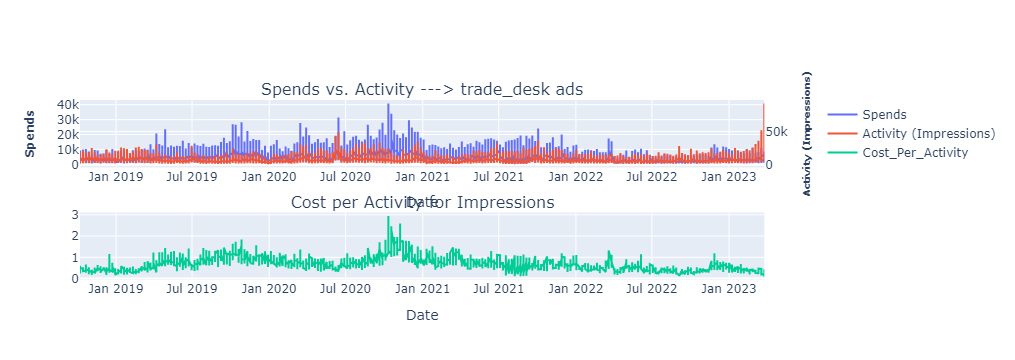

In [118]:
# Plotting the spend vs activity plot
from ta_lib.mmx.eda import get_spend_vs_activity_plot

get_spend_vs_activity_plot(
    sp_act_df,
    group_col="x_geo",
    variable_description="trade_desk ads",
    activity_type="Impressions",
    date_col="x_dt",
)

#### Spend vs Activity for each Geography

In [14]:
# Create Spend vs Activity dataframe for each geography
sp_act_df_fra = sp_act_df[sp_act_df['x_geo'] == 'fra']
sp_act_df_abd = sp_act_df[sp_act_df['x_geo'] == 'abd']
sp_act_df_edi = sp_act_df[sp_act_df['x_geo'] == 'edi']
sp_act_df_bcn = sp_act_df[sp_act_df['x_geo'] == 'bcn']
sp_act_df_lon = sp_act_df[sp_act_df['x_geo'] == 'lon']
sp_act_df_muc = sp_act_df[sp_act_df['x_geo'] == 'muc']
sp_act_df_osl = sp_act_df[sp_act_df['x_geo'] == 'osl']
sp_act_df_rot = sp_act_df[sp_act_df['x_geo'] == 'rot']
sp_act_df_trn = sp_act_df[sp_act_df['x_geo'] == 'trn']
sp_act_df_zur = sp_act_df[sp_act_df['x_geo'] == 'zur']
sp_act_df_lux = sp_act_df[sp_act_df['x_geo'] == 'lux']

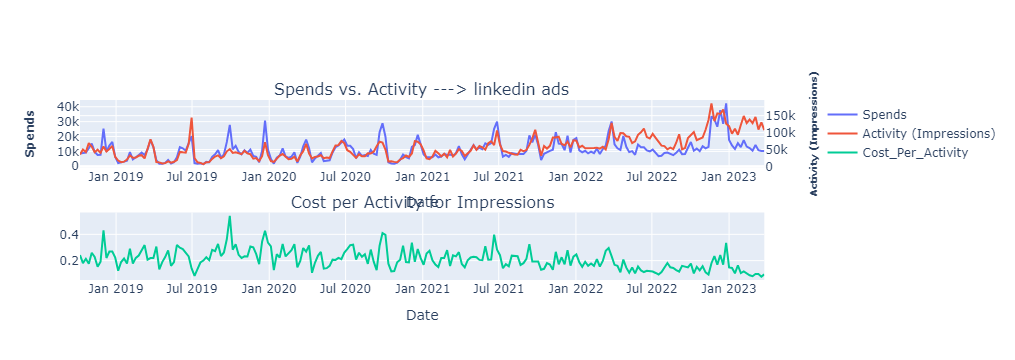

In [15]:
# Plotting the spend vs activity plot for geography
# France
get_spend_vs_activity_plot(
    sp_act_df_fra,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

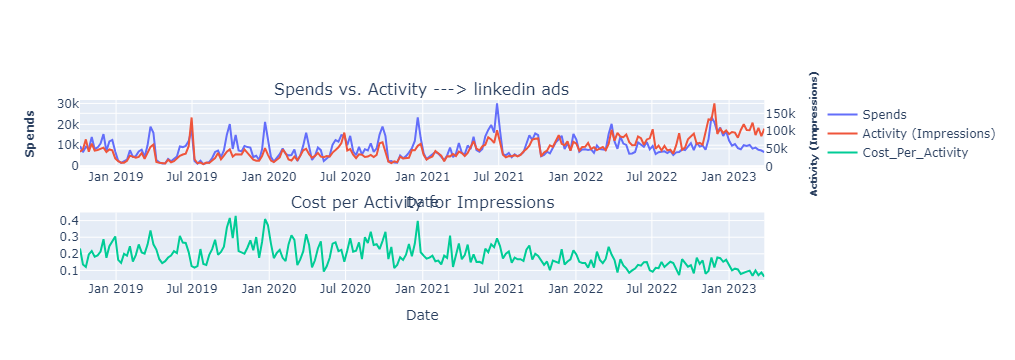

In [16]:
# ABD
get_spend_vs_activity_plot(
    sp_act_df_abd,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

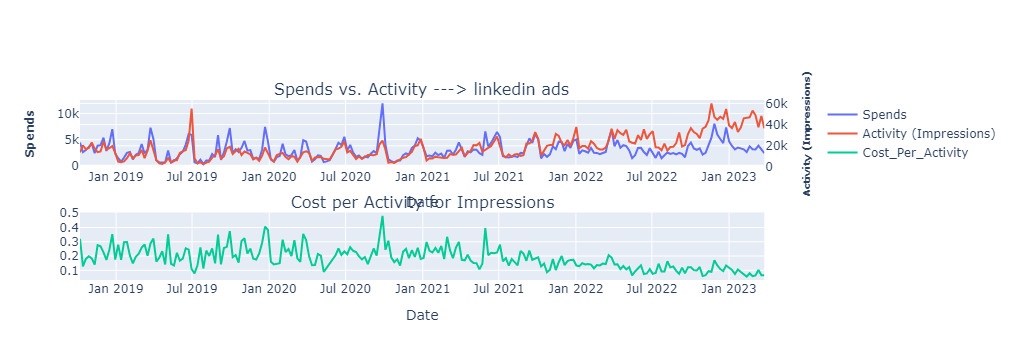

In [17]:
# EDI
get_spend_vs_activity_plot(
    sp_act_df_edi,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

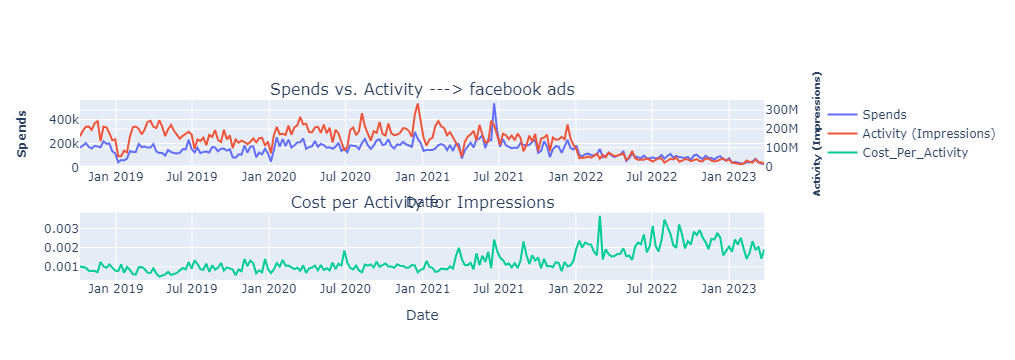

In [18]:
# BCN
get_spend_vs_activity_plot(
    sp_act_df_bcn,
    group_col="x_geo",
    variable_description="facebook ads",
    activity_type="Impressions",
    date_col="x_dt",
)

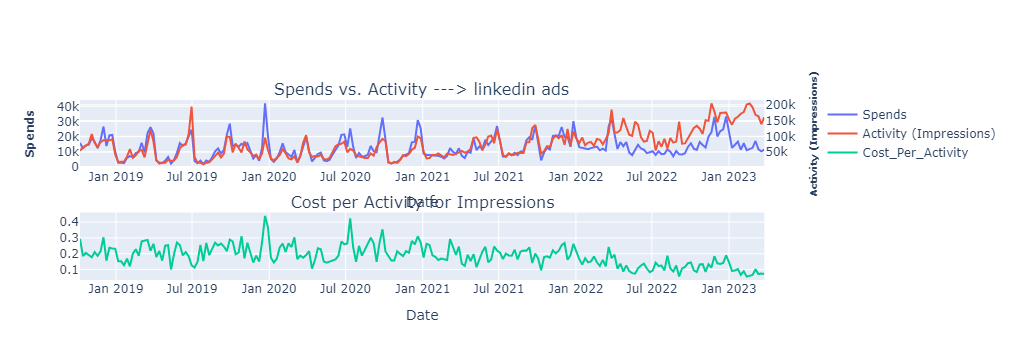

In [19]:
# Lon
get_spend_vs_activity_plot(
    sp_act_df_lon,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

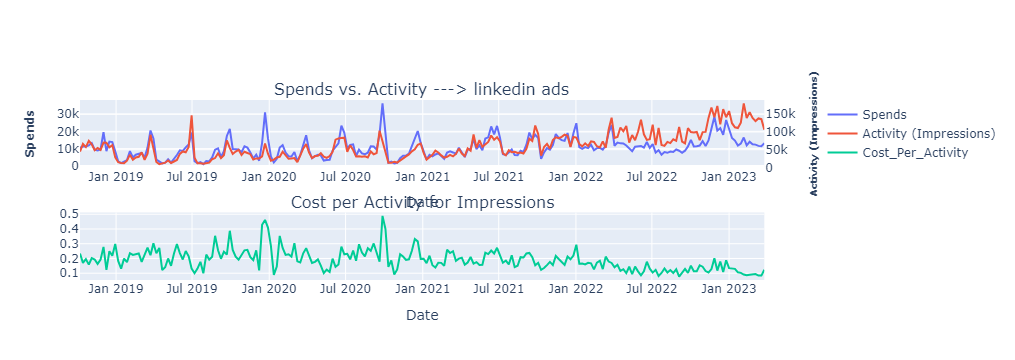

In [20]:
# MUC
get_spend_vs_activity_plot(
    sp_act_df_muc,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

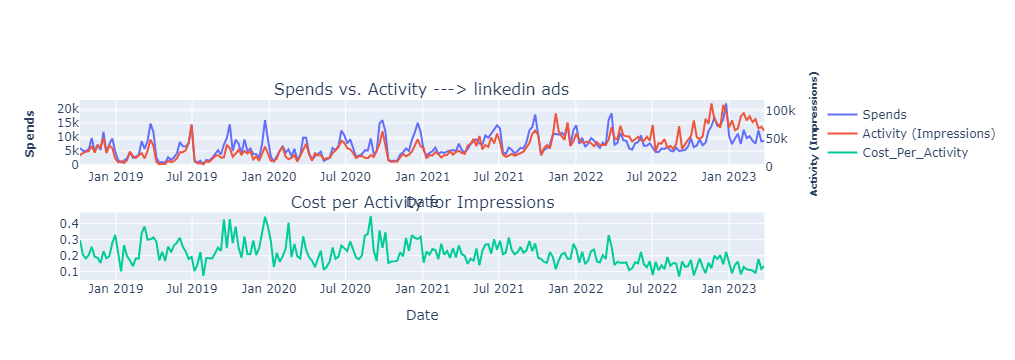

In [21]:
# OSL
get_spend_vs_activity_plot(
    sp_act_df_osl,
    group_col="x_geo",
    variable_description="linkedin ads",
    activity_type="Impressions",
    date_col="x_dt",
)

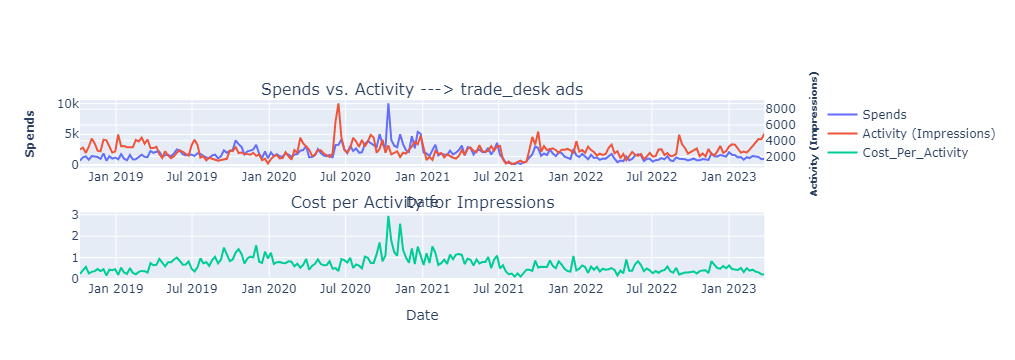

In [131]:
# ROT
get_spend_vs_activity_plot(
    sp_act_df_rot,
    group_col="x_geo",
    variable_description="trade_desk ads",
    activity_type="Impressions",
    date_col="x_dt",
)

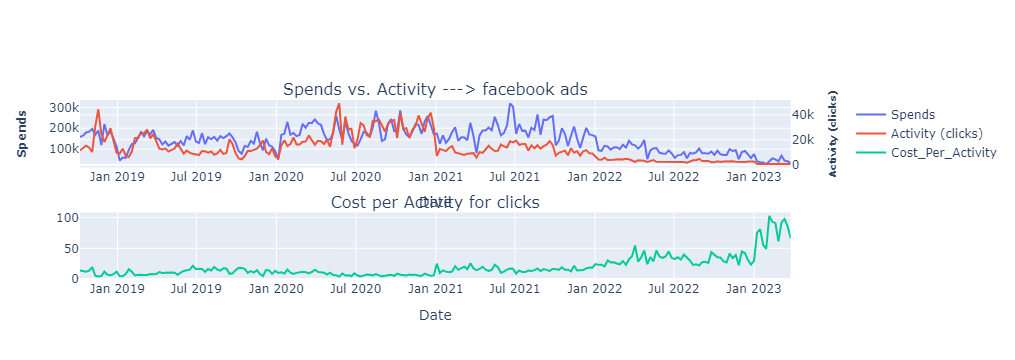

In [112]:
# TRN
get_spend_vs_activity_plot(
    sp_act_df_trn,
    group_col="x_geo",
    variable_description="facebook ads",
    activity_type="clicks",
    date_col="x_dt",
)

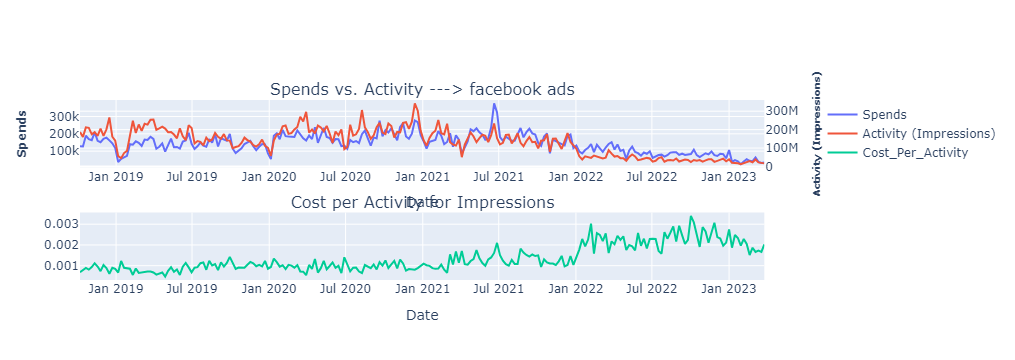

In [113]:
# ZUR
get_spend_vs_activity_plot(
    sp_act_df_zur,
    group_col="x_geo",
    variable_description="facebook ads",
    activity_type="Impressions",
    date_col="x_dt",
)

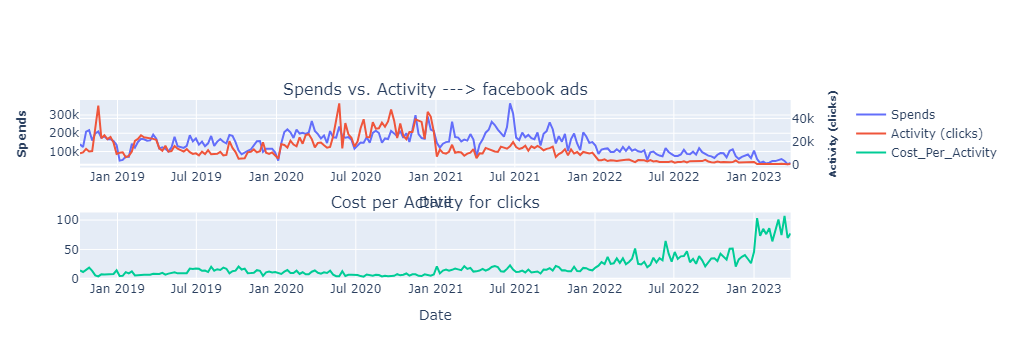

In [110]:
# LUX

out_2 = get_spend_vs_activity_plot(
            sp_act_df_lux,
            group_col="x_geo",
            variable_description="facebook ads",
            activity_type="clicks",
            date_col="x_dt",
        )
out_2
# variable_desc = ["bing ads", "facebook ads"]
# activity_type = ["impressions", "clicks"]
# for i in variable_desc:
#     for j in activity_type:
#         out_2 = get_spend_vs_activity_plot(
#             sp_act_df_fra,
#             group_col="x_geo",
#             variable_description=i,
#             activity_type=j,
#             date_col="x_dt",
#         )
#         out

In [101]:
import ta_lib.reports.api as reports
# save the plots are html
reports.create_report({"spend_vs_activity": out_2}, name="reports/spend_vs_activity_analysis")

### 2.2.2 Quarterly spends plots
The plot function is used to plot the quarterly spend data. It allows you to give the category for which you want to visualize the quarterly spend

The following steps are followed to generate the quarterly spends

1. Adding fiscal calendar that is the columns such as year, quarter and week extracted from the date column by using add_fiscal_calender
2. The quarterly spend values are obtained from the config file, which must be filled out with the correct values in a specific format. For more context on how to fill the config file. Please refer [this](https://tigeranalytics-code-templates.readthedocs-hosted.com/en/latest/code_templates/mmx.html#quarterly-spends-config-file).
3. Then we generate the quarterly spend data by using the generate_quarterly_spends_data which takes the data, dataframe containing the config file, category column name, year and quarter column
4. Following that we plot the quarterly spend plot by using the get_quarterly_spends_plot function

In [30]:
# Reading the data from the config files
quarter_df = pd.read_csv(context.config["mmx_config"]["quarterly_spend_config"])

# Adding the year,week,quarter columns to dataset
activity_df_clean = add_fiscal_calendar(activity_df_clean, ["x_dt"])

# Generate the quarterly spends data
quarter_df = generate_quarterly_spends_data(
    activity_df_clean, quarter_df, "x_geo", "Year", "Quarter"
)

In [33]:
activity_df_clean_fra = activity_df_clean[activity_df_clean['x_geo'] == 'fra']
activity_df_clean_abd = activity_df_clean[activity_df_clean['x_geo'] == 'abd']
activity_df_clean_bcn = activity_df_clean[activity_df_clean['x_geo'] == 'bcn']
activity_df_clean_edi = activity_df_clean[activity_df_clean['x_geo'] == 'edi']
activity_df_clean_lon = activity_df_clean[activity_df_clean['x_geo'] == 'lon']
activity_df_clean_lux = activity_df_clean[activity_df_clean['x_geo'] == 'lux']
activity_df_clean_muc = activity_df_clean[activity_df_clean['x_geo'] == 'muc']
activity_df_clean_osl = activity_df_clean[activity_df_clean['x_geo'] == 'osl']
activity_df_clean_rot = activity_df_clean[activity_df_clean['x_geo'] == 'rot']
activity_df_clean_trn = activity_df_clean[activity_df_clean['x_geo'] == 'trn']
activity_df_clean_zur = activity_df_clean[activity_df_clean['x_geo'] == 'zur']

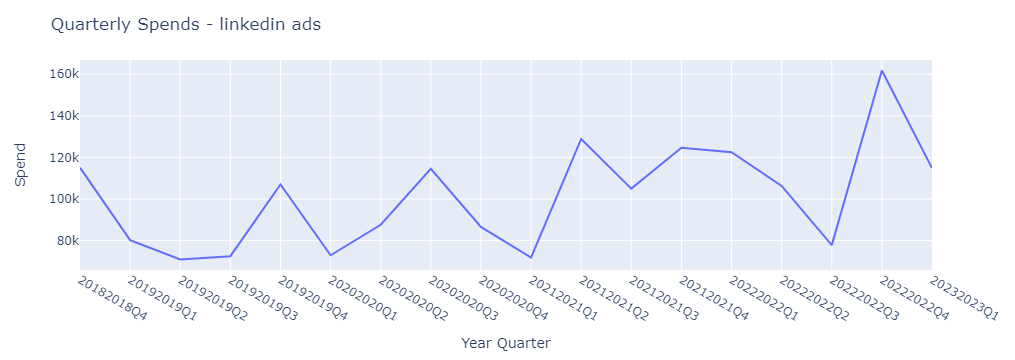

In [31]:
# plot the quarterly spends plot
# For all geographies at Overall Level
get_quarterly_spends_plot(
    quarter_df, group_col="x_geo", spend_variable_description="linkedin ads"
)

In [49]:
def quarterly_spend_plot(df, spend_variable):
    # Reading the data from the config files
    quarter_df = pd.read_csv(context.config["mmx_config"]["quarterly_spend_config"])
    
    # Generate the quarterly spends data
    quarter_df = generate_quarterly_spends_data(
        df, quarter_df, "x_geo", "Year", "Quarter"
    )
    
    return get_quarterly_spends_plot(
        quarter_df, group_col="x_geo", spend_variable_description=spend_variable
    )

In [120]:
variable_description_list = list(sp_act_df["variable_description"].unique())

In [134]:
for i in variable_description_list:
    quarterly_spend_plot(activity_df_clean_fra, i)

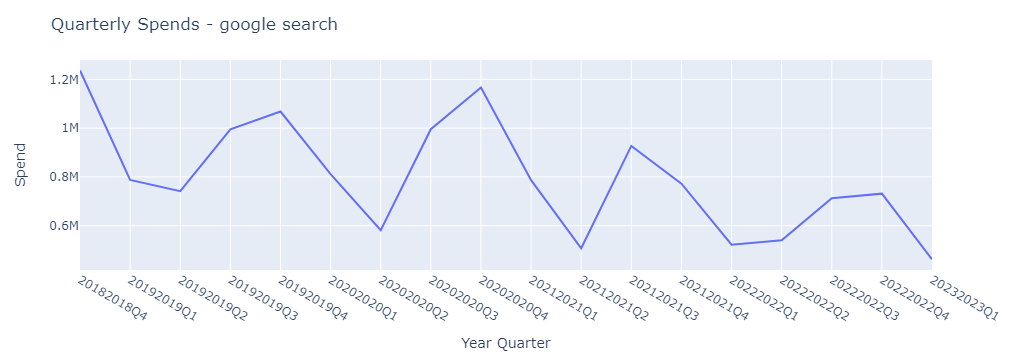

In [50]:
# FRANCE

quarterly_spend_plot(activity_df_clean_fra, "google search")

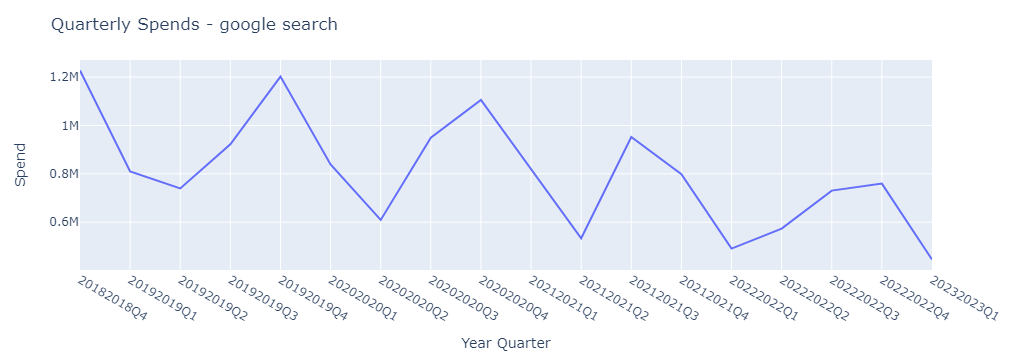

In [51]:
# EDI

quarterly_spend_plot(activity_df_clean_edi, "google search")

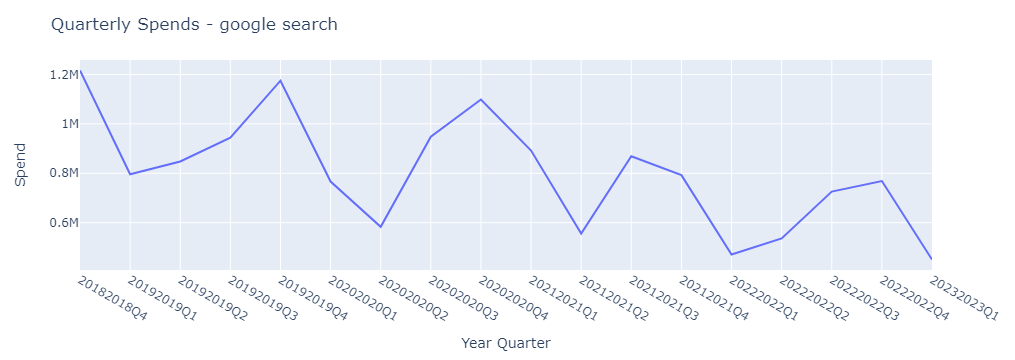

In [52]:
# ABD

quarterly_spend_plot(activity_df_clean_abd, "google search")

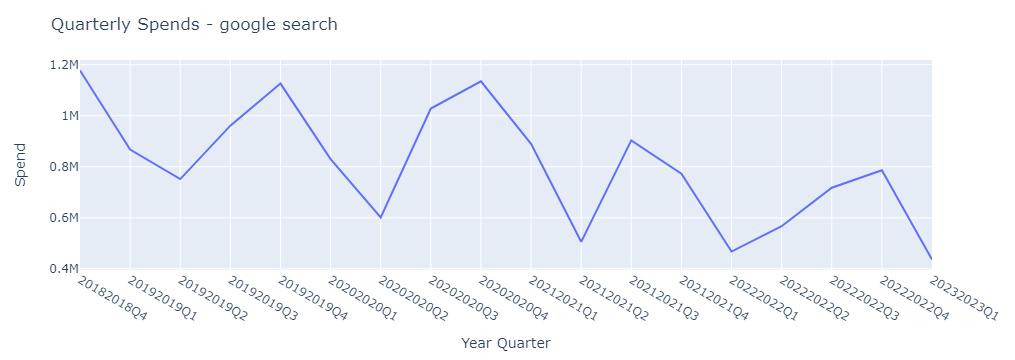

In [53]:
# BCN

quarterly_spend_plot(activity_df_clean_bcn, "google search")

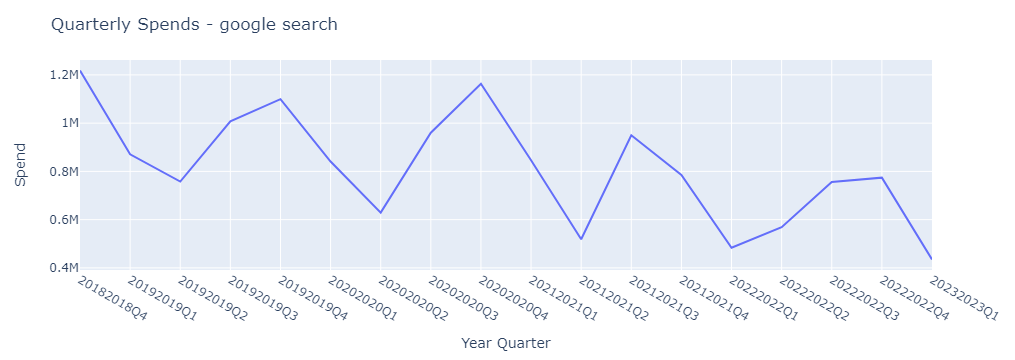

In [54]:
# LON

quarterly_spend_plot(activity_df_clean_lon, "google search")

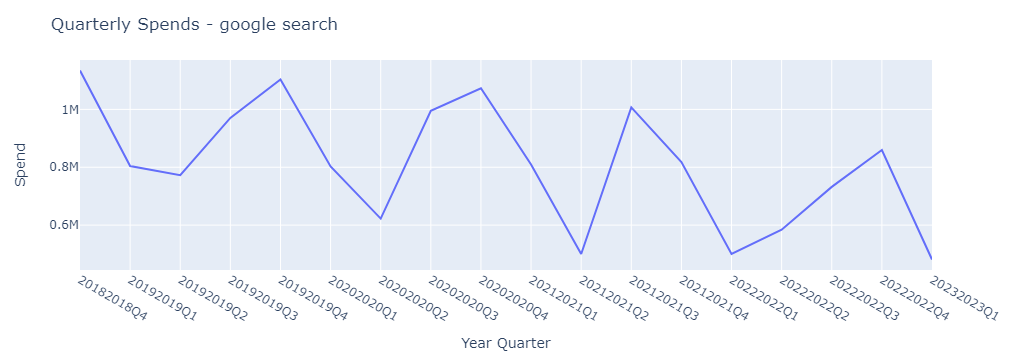

In [55]:
# LUX

quarterly_spend_plot(activity_df_clean_muc, "google search")

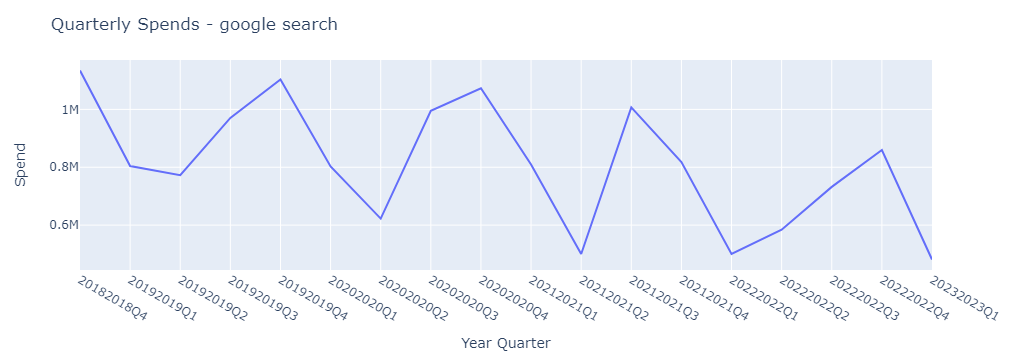

In [56]:
# MUC
quarterly_spend_plot(activity_df_clean_muc, "google search")

In [133]:
# OSL
for i in variable_description_list:
    quarterly_spend_plot(activity_df_clean_osl, i)
    plt.show()

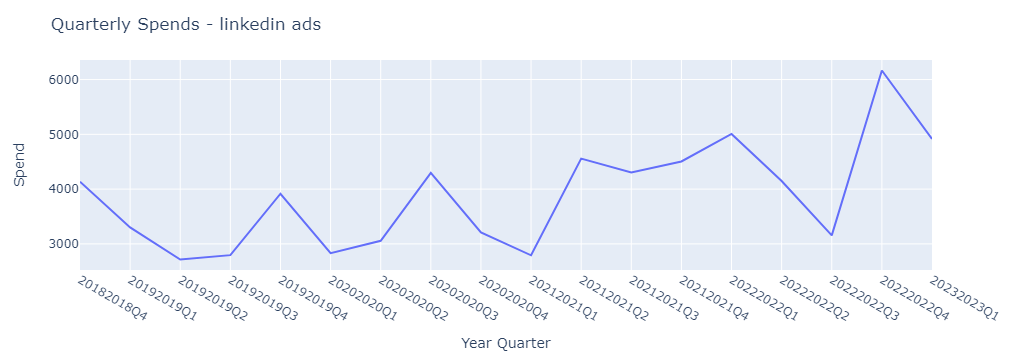

In [129]:
# ROT

quarterly_spend_plot(activity_df_clean_rot, "linkedin ads")

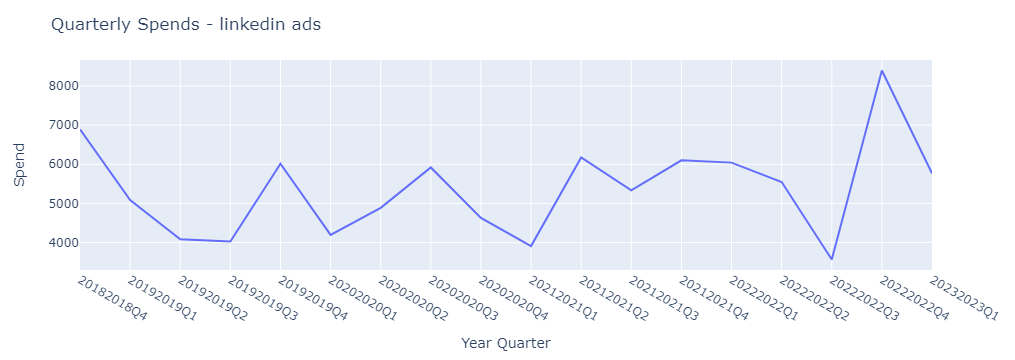

In [127]:
# TRN

quarterly_spend_plot(activity_df_clean_trn, "linkedin ads")

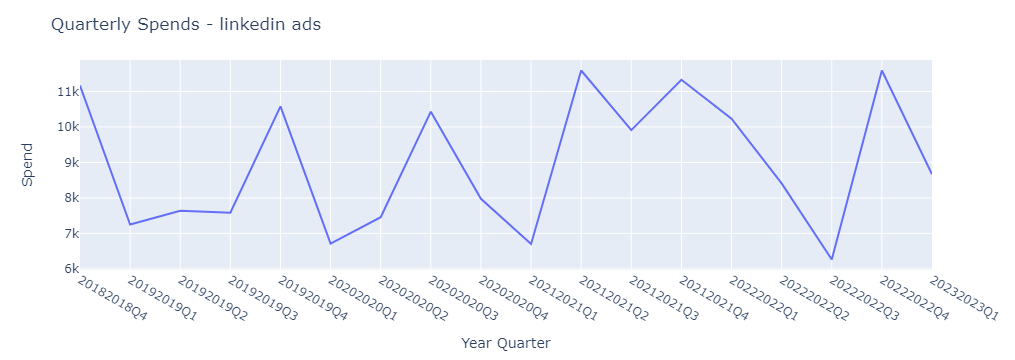

In [128]:
# ZUR
quarterly_spend_plot(activity_df_clean_zur, "linkedin ads")

## 2.3 Business intuition features

This section can go into production code if these features are used in final model

#### Linear Trend
The add_linear_trend function adds a linear trend column ``trend`` to the dataset. Trends represent long-term changes in the data over time. By incorporating a linear trend, market mix models can capture the underlying growth or decline in the dependent variable that is not accounted for by the other marketing variables. This helps distinguish between the impact of marketing activities and the overall trend in the market.

#### Seasonality
The get_seasonality_column function adds a seasonality column ``s_index_weekly`` (by default granularity is set to weekly) to the dataset. Seasonality captures the regular, repetitive patterns in the data that occur within a specific time period (e.g., weekly or monthly). By accounting for seasonality, market mix models can separate the effect of marketing activities from the inherent fluctuations caused by seasonal factors. This allows for a more accurate assessment of the true impact of marketing efforts.

Including both linear trend and seasonality columns in the dataset allows market mix models to better capture the complex dynamics of marketing activities and their effects on the dependent variable. It helps analysts identify the specific contributions of marketing channels, promotions, or other factors while accounting for underlying trends and seasonal variations. Ultimately, this enhances the accuracy of the model's predictions and provides valuable insights for optimizing marketing strategies and resource allocation.

In [61]:
# Group the data at Date level as we want to create model at overall level 
new_activity_df_clean = activity_df_clean.groupby(
    ['x_dt','Year', 'Month', 'Week', 'Quarter'], as_index=False
).agg({
    'branch_prospect_visits': 'sum', 
    'branch_employee_count': 'sum', 
    'cust_sat_score': 'mean', 
    'ec_djia_idx': 'mean', 
    'ec_is_bull': 'mean', 
    'ec_cpi': 'mean', 
    'ec_tbill_3m': 'mean', 
    'ec_psavert': 'mean', 
    'ec_sp500_idx': 'mean', 
    'gqv_n_actra_gix': 'mean', 
    'gqv_n_brok_gix': 'mean', 
    'gqv_n_retire_gix': 'mean', 
    'web_new_customer_logins': 'sum', 
    'm_fb_n_clk': 'sum', 
    'm_fb_n_imp': 'sum', 
    'm_fb_n_sp': 'sum',
    'm_bing_l_clk': 'sum', 
    'm_bing_l_imp': 'sum', 
    'm_bing_l_sp': 'sum', 
    'm_google_n_clk': 'sum', 
    'm_google_n_imp': 'sum', 
    'm_google_n_sp': 'sum',
    'm_youtube_n_clk': 'sum', 
    'm_youtube_n_imp': 'sum', 
    'm_youtube_n_sp': 'sum',
    'm_trade_desk_l_clk': 'sum', 
    'm_trade_desk_l_imp': 'sum', 
    'm_trade_desk_l_sp': 'sum',
    'm_linkedin_l_clk': 'sum', 
    'm_linkedin_l_imp': 'sum', 
    'm_linkedin_l_sp': 'sum',
    'new_customers': 'sum'
})


In [62]:
new_activity_df_clean.shape

(234, 37)

In [63]:
df = new_activity_df_clean.copy()
# Adding the trends and seasonality columns to the dataframe
df = add_linear_trend(df, "x_dt")
df = get_seasonality_column(
    df, "new_customers", date_col="x_dt", decompose_method="multiplicative"
)

In [65]:
# def drop_single_value_columns(df):
#     # Check if each column contains only 0 values
#     columns_to_drop = df.columns[(df == 0).all()]
#     # print(columns_to_drop)
    
#     # Drop identified columns
#     df = df.drop(columns=columns_to_drop)

#     return df

In [66]:
# Drop columns with single 0 value
df = remove_columns_with_all_zeros(df)

df.shape

(234, 39)

In [67]:
df.columns

Index(['x_dt', 'Year', 'Month', 'Week', 'Quarter', 'branch_prospect_visits',
       'branch_employee_count', 'cust_sat_score', 'ec_djia_idx', 'ec_is_bull',
       'ec_cpi', 'ec_tbill_3m', 'ec_psavert', 'ec_sp500_idx',
       'gqv_n_actra_gix', 'gqv_n_brok_gix', 'gqv_n_retire_gix',
       'web_new_customer_logins', 'm_fb_n_clk', 'm_fb_n_imp', 'm_fb_n_sp',
       'm_bing_l_clk', 'm_bing_l_imp', 'm_bing_l_sp', 'm_google_n_clk',
       'm_google_n_imp', 'm_google_n_sp', 'm_youtube_n_clk', 'm_youtube_n_imp',
       'm_youtube_n_sp', 'm_trade_desk_l_clk', 'm_trade_desk_l_imp',
       'm_trade_desk_l_sp', 'm_linkedin_l_clk', 'm_linkedin_l_imp',
       'm_linkedin_l_sp', 'new_customers', 'trend', 's_index_weekly'],
      dtype='object')

In [68]:
idv = ['m_fb_n_clk', 'm_fb_n_imp', 'm_fb_n_sp',
       'm_bing_l_clk', 'm_bing_l_imp', 'm_bing_l_sp', 'm_google_n_clk',
       'm_google_n_imp', 'm_google_n_sp', 'm_youtube_n_clk', 'm_youtube_n_imp',
       'm_youtube_n_sp', 'm_trade_desk_l_clk', 'm_trade_desk_l_imp',
       'm_trade_desk_l_sp', 'm_linkedin_l_clk', 'm_linkedin_l_imp',
       'm_linkedin_l_sp']

In [69]:
# let's check correlation of impression & clicks with target variable for different marketing activities

from ta_lib.mmx.eda import compute_idv_dv_correlation
corr_df = compute_idv_dv_correlation(df, idv, dv_col=['new_customers'])
corr_df#[corr_df["new_customers"]>0.4].sort_values(by = "new_customers", ascending = False)

new_customers
m_fb_n_clk              -0.040608
m_fb_n_imp              -0.170165
m_fb_n_sp                0.025992
m_bing_l_clk             0.437081
m_bing_l_imp             0.459692
m_bing_l_sp              0.488798
m_google_n_clk          -0.193530
m_google_n_imp           0.122396
m_google_n_sp           -0.122631
m_youtube_n_clk          0.182457
m_youtube_n_imp          0.295395
m_youtube_n_sp           0.192033
m_trade_desk_l_clk       0.689244
m_trade_desk_l_imp       0.149010
m_trade_desk_l_sp        0.043202
m_linkedin_l_clk         0.656756
m_linkedin_l_imp         0.393458
m_linkedin_l_sp          0.213185

In [72]:
columns_to_select = ['m_fb_n_clk', 'm_bing_l_imp', 'm_google_n_imp', 'm_youtube_n_imp', 'm_trade_desk_l_clk', 'm_linkedin_l_clk']

#### Half-life
* Advertising half-life is calculated in the similar way as we estimate decay half-life for radioactive substances.

* Let us assume that in time-period t+n, A t would have decayed to A t /2 assuming there is no advertisement present in between t and t+n.

We will have:

* A_(t+n)= λ^n*A_t ,where T_t=0 for all t ∈ (t,t+n]

Considering n as a half-life we have:

* A_t/2= λ^n*A_t
* λ=e^〖(log〗⁡〖0.5)/n〗
* In general, acceptable range of half-life(n) varies between 2-5 weeks.

* We experiment with different decay rate λ based on acceptable range of half-life. We create adstock transformation with each λ and choose the best correlated adstock feature.

#### Adstock variables
* Adstock in market mix modelling is accounting the impact of an advertisement on consumer may not be an immediate, but rather may build over time.
* We use simple decay model for building Adsctock as given below:
    * A_t=T_t+ λ*A_(t-1) ,t=1,2,3…..n
        * Where A t is the Adstock transformation at time t,
        * T t is the value of advertising variable at time t and
        * λ is the decay rate or lag weight parameter.
* This equation provides a lag structure in a way that it considers all the advertisements in the past and their discounted impact as below:
    * A_t=T_t+ λT_(t-1)+ λ^2T_(t-2)+ λ^3T_(t-3)+⋯…………+ λ^nT_(t-n)
    * However as λ is less than 1 , if n increases λ n *T t-n does not contribute much.

In [76]:
ad_stocked_columns = create_adstock(
    df,
    "x_dt",
    [3, 4, 5],
    max_memory=0,
    columns = columns_to_select,
    suffix="adstock",
)

# Merging the adstocked columns with the original dataframe
df = pd.merge(df, ad_stocked_columns, on=["x_dt"], how="inner")

#### Lag variables
* Lag variables are included in market mix models to consider the time it takes for marketing efforts to influence consumer behavior and business outcomes, helping to understand the long-term effects and make better decisions about resource allocation.
* The lag variable measures the carry-over effect of marketing actions, recognizing that marketing effects may not be immediate and can extend over time.
* It is created by shifting the values of marketing input variables or outcome variables by a specific time period.


In [77]:
# Creating a lag columns
lagstock_columns = create_lag(
    data=df,
    date_col="x_dt",
    lags=[3, 4, 5],
    # group_cols=["x_geo"],
    columns=columns_to_select,
)

# Merging the lagstock columns with the dataframe
df = pd.merge(df, lagstock_columns, on=["x_dt"], how="inner")

In [78]:
df.head()

x_dt  Year     Month Week Quarter  branch_prospect_visits  \
0 2018-10-07  2018   October   40  2018Q4                    55.0   
1 2018-10-14  2018   October   41  2018Q4                    58.0   
2 2018-10-21  2018   October   42  2018Q4                    63.0   
3 2018-10-28  2018   October   43  2018Q4                    60.0   
4 2018-11-04  2018  November   44  2018Q4                    51.0   

   branch_employee_count  cust_sat_score  ec_djia_idx  ec_is_bull  ...  \
0                  471.0            61.0     26665.61    0.456621  ...   
1                  470.0            61.0     25605.53    0.306061  ...   
2                  470.0            61.0     25515.89    0.339350  ...   
3                  470.0            61.0     24953.02    0.279693  ...   
4                  476.0            57.0     25016.98    0.379310  ...   

   m_google_n_imp_4  m_youtube_n_imp_4  m_trade_desk_l_clk_4  \
0       780378676.0        103715801.0                5761.0   
1       780378676.0        103715801.0                5761.0   
2       780378676.0        103715801.0                5761.0   
3       780378676.0        103715801.0                5761.0   
4       780378676.0        103715801.0                5761.0   

   m_linkedin_l_clk_4  m_fb_n_clk_5  m_bing_l_imp_5  m_google_n_imp_5  \
0             10332.0      117738.0       2036530.0       780378676.0   
1             10332.0      117738.0       2036530.0       780378676.0   
2             10332.0      117738.0       2036530.0       780378676.0   
3             10332.0      117738.0       2036530.0       780378676.0   
4             10332.0      117738.0       2036530.0       780378676.0   

   m_youtube_n_imp_5  m_trade_desk_l_clk_5  m_linkedin_l_clk_5  
0        103715801.0                5761.0             10332.0  
1        103715801.0                5761.0             10332.0  
2        103715801.0                5761.0             10332.0  
3        103715801.0                5761.0             10332.0  
4        103715801.0                5761.0             10332.0  

[5 rows x 75 columns]

#### S Curve
* S curve captures the notions of threshold and saturation in the data.

In [79]:
s_curve_vars = [
    "m_fb_n_sp", 
    "m_google_n_sp", 
    "m_bing_l_sp", 
    "m_linkedin_l_sp", 
    "m_trade_desk_l_sp",
]
s_vars = s_curve_vars + list(df.columns[df.columns.str.endswith("adstock")])

# Beta values control the pattern that are data specific
beta = [0.00000064, 0.000012, 0.0000055]
# Alpha values
alpha = [2, 5, 6]

# Adding the scurve transformation t the dataframe
data_curve, map_df = get_scurve_transform(
    df,
    alpha=alpha,
    beta=beta,
    columns=s_vars,
    date_col="x_dt",
    # group_cols=["x_geo"],
)

In [80]:
transformed_df = pd.merge(df, data_curve, on=["x_dt"], how="inner")

In [81]:
# create a sample dataframe with minimal processing

transformed_df_processed = (
    transformed_df
    # tweak to test pipeline quickly or profile performance
    # any additional processing/cleaning
)

# Any verifications on the data
from ta_lib.eda.api import get_variable_summary

display_as_tabs(
    [
        (
            "Summary",
            f"Length: {len(transformed_df_processed)}, Columns: {len(transformed_df_processed.columns)}",
        ),
        ("Variable summary", get_variable_summary(transformed_df_processed)),
        ("head", transformed_df.head(5).T),
        ("tail", transformed_df.tail(5).T),
    ]
)

Tabs
    [0] Markdown(str, name='Summary')
    [1] DataFrame(height=300, name='Variable summary', sizing_mode='fixed', value=                          ..., width=800)
    [2] DataFrame(height=300, name='head', sizing_mode='fixed', value=              ..., width=800)
    [3] DataFrame(height=300, name='tail', sizing_mode='fixed', value=              ..., width=800)

In [215]:
save_dataset(context, transformed_df_processed, "processed/mmx/")

### Create Business Intution features at Geography Level

In [83]:
activity_df_clean['x_geo'].unique()

array(['fra', 'rot', 'zur', 'lux', 'lon', 'muc', 'osl', 'trn', 'edi',
       'abd', 'bcn'], dtype=object)

In [87]:
df = drop_single_value_columns(df)

In [88]:
corr_df = compute_idv_dv_correlation(df, idv, dv_col=['new_customers'])
corr_df

new_customers
m_fb_n_clk              -0.192969
m_fb_n_imp              -0.178726
m_fb_n_sp               -0.174609
m_bing_l_clk             0.531314
m_bing_l_imp             0.541183
m_bing_l_sp              0.543844
m_google_n_clk          -0.151219
m_google_n_imp           0.108710
m_google_n_sp           -0.116093
m_youtube_n_clk          0.377659
m_youtube_n_imp          0.493031
m_youtube_n_sp           0.386893
m_trade_desk_l_clk       0.555630
m_trade_desk_l_imp       0.132754
m_trade_desk_l_sp        0.059073
m_linkedin_l_clk         0.567743
m_linkedin_l_imp         0.440927
m_linkedin_l_sp          0.284881

In [91]:
columns_to_select = ["m_fb_n_imp", "m_bing_l_imp", "m_google_n_imp", "m_youtube_n_imp", "m_trade_desk_l_clk", "m_linkedin_l_clk"]
spend_col = [i for i in df.columns if i.endswith('_sp')]

In [93]:
def business_features_geo(activity_df_clean, columns_to_select):
    df = activity_df_clean.copy()
    geo = df['x_geo'].unique()[0]
    
    # Drop columns with single unique value
    df = remove_columns_with_all_zeros(df)

    spend_col = [i for i in df.columns if i.endswith('_sp')]
    
    # Adding the trends and seasonality columns to the dataframe
    df = add_linear_trend(df, "x_dt")
    df = get_seasonality_column(
        df, "new_customers", date_col="x_dt", decompose_method="multiplicative"
    )

    # Creating Adstock transformation
    ad_stocked_columns = create_adstock(
        df,
        "x_dt",
        [3, 4, 5],
        group_cols=["x_geo"],
        max_memory=0,
        columns=columns_to_select,
        suffix="adstock",
    )
    
    # Merging the adstocked columns with the original dataframe
    df = pd.merge(df, ad_stocked_columns, on=["x_geo", "x_dt"], how="inner")

    # Creating a lag columns
    lagstock_columns = create_lag(
        data=df,
        date_col="x_dt",
        lags=[3, 4, 5],
        group_cols=["x_geo"],
        columns=columns_to_select,
    )
    
    # Merging the lagstock columns with the dataframe
    df = pd.merge(df, lagstock_columns, on=["x_geo", "x_dt"], how="inner")


    # Creating s curve transformations
    s_curve_vars = spend_col
    s_vars = s_curve_vars + list(df.columns[df.columns.str.endswith("adstock")])
    
    # Beta values control the pattern that are data specific
    beta = [0.00000064, 0.000012]
    # Alpha values
    alpha = [2, 5]
    
    # Adding the scurve transformation t the dataframe
    data_curve, map_df = get_scurve_transform(
        df,
        alpha=alpha,
        beta=beta,
        columns=s_vars,
        date_col="x_dt",
        group_cols=["x_geo"],
    )


    transformed_df = pd.merge(df, data_curve, on=["x_geo", "x_dt"], how="inner")

    # save_dataset(context, transformed_df, "processed/mmx/")
    transformed_df.to_csv(f"../../data/processed/mmx/transformed_df_{geo}.csv", index = False)

    return transformed_df

In [186]:
transformed_df_fra = business_features_geo(activity_df_clean_fra)
transformed_df_rot = business_features_geo(activity_df_clean_rot)
transformed_df_zur = business_features_geo(activity_df_clean_zur)
transformed_df_lux = business_features_geo(activity_df_clean_lux)
transformed_df_lon = business_features_geo(activity_df_clean_lon)
transformed_df_muc = business_features_geo(activity_df_clean_muc)
transformed_df_osl = business_features_geo(activity_df_clean_osl)
transformed_df_trn = business_features_geo(activity_df_clean_trn)
transformed_df_edi = business_features_geo(activity_df_clean_edi)
transformed_df_abd = business_features_geo(activity_df_clean_abd)
transformed_df_bcn = business_features_geo(activity_df_clean_bcn)